In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta


In [ ]:
sp500 =pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

symbol_list = sp500['Symbol'].to_list()
end_date ='2024-06-17'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbol_list, start=start_date, end=end_date).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df

[***************       31%%                      ]  156 of 503 completed

KeyboardInterrupt: 

[*********************100%%**********************]  501 of 503 completed

<Axes: xlabel='date'>

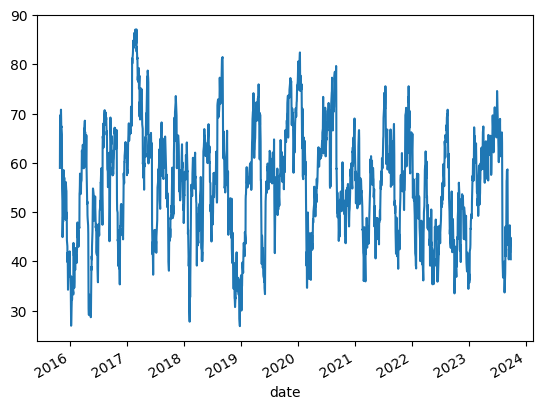

In [ ]:
# Calculate the features and techical indicators for reach stock 
df
df['garman_klass_vol'] =((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
df.xs('AAPL', level=1)['rsi'].plot()

In [ ]:
# Bollingr bands
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr =pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['adj close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1,group_keys=False).apply(compute_atr)


def compute_macd(group):
    # Calculate MACD for the group
    macd = pandas_ta.macd(close=group, fast=12, slow=26, signal=9)['MACD_12_26_9']
    # Normalize the MACD values
    normalized_macd = macd.sub(macd.mean()).div(macd.std())
    return normalized_macd

# Apply the revised compute_macd function
# Ensure the index is properly aligned for re-assignment
df['macd'] = df.groupby(level=1)['adj close'].transform(compute_macd)
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6


In [ ]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483555   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684566   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478703   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736305   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000998        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005572        NaN       NaN   
           ABBV     12842800.0         -0.054655        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146733  4.474461   
           YUM       1500600.0         -0.000051  36.057205  4.803542   
           ZBH       3610500.0          0.000099  31.893231  4.739379   
           ZBRA       355400.0          0.000133  29.494977  5.396491   
           ZTS       1463200.0          0.000062  42.623470  5.150335   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.913559  
           AAL          NaN       NaN       NaN       NaN     279.420098  
           AAPL         NaN       NaN       NaN       NaN    7243.972380  
           ABBV         NaN       NaN       NaN       NaN     466.641852  
           ABT          NaN       NaN       NaN       NaN     411.369558  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.557239  4.640017 -2.967042 -2.159188     117.344890  
           YUM     4.833746  4.863950 -2.813230 -1.363696     183.389847  
           ZBH     4.779385  4.819390 -2.065619 -0.881067     403.591519  
           ZBRA    5.535220  5.673948 -0.057389 -1.600791      79.595386  
           ZTS     5.209470  5.268604 -0.720919 -1.188279     256.861393  

[988898 rows x 14 columns]

In [ ]:
# Aggregate to monthy level and filter tip 150 most liquid stocks for each month
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume','open','high','low','close','close']]
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1)).dropna()


/var/folders/sl/mz3bx1nj3_94rwgrcx6b1pqh0000gn/T/ipykernel_3694/508374790.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1)).dropna()
/var/folders/sl/mz3bx1nj3_94rwgrcx6b1pqh0000gn/T/ipykernel_3694/508374790.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1)).dropna()
/var/folders/sl/mz3bx1nj3_94rwgrcx6b1pqh0000gn/T/ipykernel_3694/508374790.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2

In [ ]:
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.992821   39.023186         -0.001992  73.421506   
           AAL        287.915790   39.429935         -0.000966  40.719026   
           AAPL      4029.441854   26.890562         -0.003209  55.537355   
           ABBV       337.563908   40.393528         -0.059549  49.376862   
           ABT        211.659048   38.293568         -0.011216  56.962509   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       154.361755   78.356506         -0.000097  33.116283   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.670368  107.862022          0.000131  55.245464   
           GEHC       212.275852   66.130219          0.000185  40.922335   
           KVUE       677.910277   20.218124          0.000032  35.706337   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.516814  3.591231  3.665648 -0.896333  0.567157  
           AAL     3.646341  3.726010  3.805679  1.473838 -0.418772  
           AAPL    3.244764  3.289701  3.334638 -0.295440 -0.142789  
           ABBV    3.702351  3.751730  3.801109  0.572009  0.145677  
           ABT     3.629883  3.652307  3.674730  0.553864  0.335557  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.357419  4.403258  4.449098 -2.269284 -1.534535  
           ABNB    4.849260  4.933744  5.018227 -1.006939 -0.037854  
           CEG     4.642564  4.683111  4.723657 -0.705544  0.366876  
           GEHC    4.139661  4.198053  4.256444 -0.905988 -1.116463  
           KVUE    2.974628  3.053117  3.131606 -2.715687 -1.435621  

[46692 rows x 9 columns]

In [ ]:
# Adjust the rolling operation to use min_periods
data['dollar_volume'] = (data.loc[:,'dollar_volume']
                         .unstack('ticker')
                         .rolling(window=60, min_periods=1).mean()  # Use min_periods=1 to allow calculation with fewer data points
                         .stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data['dollar_vol_rank'] = data['dollar_vol_rank'].astype(int)
data = data[data['dollar_vol_rank']<150].drop(['dollar_vol_rank','dollar_volume'], axis=1)
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2015-11-30 AAL      39.429935         -0.000966  40.719026  3.646341   
           AAPL     26.890562         -0.003209  55.537355  3.244764   
           ABBV     40.393528         -0.059549  49.376862  3.702351   
           ABT      38.293568         -0.011216  56.962509  3.629883   
           ACN      93.640083         -0.007419  59.371754  4.507471   
...                       ...               ...        ...       ...   
2023-09-30 XOM     114.292961          0.000026  59.440186  4.685927   
           MRNA     98.120003          0.000146  38.747314  4.572266   
           UBER     44.270000          0.000441  45.005268  3.784202   
           ABNB    132.279999          0.000213  44.494127  4.849260   
           KVUE     20.218124          0.000032  35.706337  2.974628   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2015-11-30 AAL     3.726010  3.805679  1.473838 -0.418772  
           AAPL    3.289701  3.334638 -0.295440 -0.142789  
           ABBV    3.751730  3.801109  0.572009  0.145677  
           ABT     3.652307  3.674730  0.553864  0.335557  
           ACN     4.532063  4.556655  0.281218  0.039553  
...                     ...       ...       ...       ...  
2023-09-30 XOM     4.726384  4.766840 -1.386997  1.400623  
           MRNA    4.676047  4.779827 -0.529511 -0.376899  
           UBER    3.840973  3.897745 -0.746098 -0.133973  
           ABNB    4.933744  5.018227 -1.006939 -0.037854  
           KVUE    3.053117  3.131606 -2.715687 -1.435621  

[14155 rows x 8 columns]

In [ ]:
# calculate monthly returns for different time horizons as features
def calculate_returns(df):
    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        
        df[f'return_{lag}m'] = df['adj close'].pct_change(lag).pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1)

    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-11-30 AAL      44.876514          0.000189  71.397570  3.630062   
           AAPL     25.681046         -0.002503  48.015317  3.211247   
           ABBV     43.867027         -0.044457  49.727602  3.697701   
           ABT      33.270943         -0.008821  39.665383  3.500585   
           ACN     106.411911         -0.006283  54.807772  4.638482   
...                       ...               ...        ...       ...   
2023-09-30 WMT      53.597538         -0.000041  54.722538  3.966210   
           XOM     114.292961          0.000026  59.440186  4.685927   
           MRNA     98.120003          0.000146  38.747314  4.572266   
           UBER     44.270000          0.000441  45.005268  3.784202   
           ABNB    132.279999          0.000213  44.494127  4.849260   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2016-11-30 AAL     3.747566  3.865069  1.182208  2.344164   0.146730   
           AAPL    3.241460  3.271673 -1.073966 -0.314781  -0.021601   
           ABBV    3.773575  3.849449  0.292785 -0.257988   0.089996   
           ABT     3.538099  3.575613 -0.647604 -0.575623  -0.029817   
           ACN     4.662587  4.686693  0.160180  0.031425   0.027443   
...                     ...       ...       ...       ...        ...   
2023-09-30 WMT     3.984005  4.001800 -2.579274  0.399459  -0.000676   
           XOM     4.726384  4.766840 -1.386997  1.400623   0.046947   
           MRNA    4.676047  4.779827 -0.529511 -0.376899  -0.132219   
           UBER    3.840973  3.897745 -0.746098 -0.133973  -0.062672   
           ABNB    4.933744  5.018227 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2016-11-30 AAL      0.127700   0.086493   0.065515   0.014886    0.010841  
           AAPL    -0.008718   0.015430   0.018834   0.016838   -0.003828  
           ABBV    -0.013645  -0.014453  -0.002749   0.015097    0.006898  
           ABT     -0.048194  -0.030325  -0.004603   0.000125   -0.011648  
           ACN     -0.006148   0.016178   0.002371   0.021900    0.010712  
...                      ...        ...        ...        ...         ...  
2023-09-30 WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           ABNB    -0.067704   0.010603   0.010289   0.048608    0.019401  

[11895 rows x 14 columns]

In [ ]:
# Download Fama-French factors and calculate rolling factor betas

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start='2010')[0].drop('RF',axis=1)

/var/folders/sl/mz3bx1nj3_94rwgrcx6b1pqh0000gn/T/ipykernel_3694/3687003531.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start='2010')[0].drop('RF',axis=1)


In [ ]:
factor_data.index = pd.to_datetime(factor_data.index)
factor_data.resample('M').last().div(100)
factor_data.index.name ='date'
factor_data =factor_data.join(data['return_1m']).sort_index()

factor_data

/var/folders/sl/mz3bx1nj3_94rwgrcx6b1pqh0000gn/T/ipykernel_3694/2060447610.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  factor_data.resample('M').last().div(100)


Mkt-RF   SMB   HML   RMW   CMA  return_1m
date       ticker                                           
2016-11-30 AAL      -0.25 -0.17  2.21 -1.43  1.99   0.146730
           AAPL     -0.25 -0.17  2.21 -1.43  1.99  -0.021601
           ABBV     -0.25 -0.17  2.21 -1.43  1.99   0.089996
           ABT      -0.25 -0.17  2.21 -1.43  1.99  -0.029817
           ACN      -0.25 -0.17  2.21 -1.43  1.99   0.027443
...                   ...   ...   ...   ...   ...        ...
2023-08-31 VRTX     -0.08 -0.19  0.21  0.06 -0.26  -0.011353
           VZ       -0.08 -0.19  0.21  0.06 -0.26   0.026408
           WFC      -0.08 -0.19  0.21  0.06 -0.26  -0.098507
           WMT      -0.08 -0.19  0.21  0.06 -0.26   0.020819
           XOM      -0.08 -0.19  0.21  0.06 -0.26   0.045333

[8457 rows x 6 columns]

In [ ]:
# Filter out stocks with less than 10 months of data
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations>=10]

valid_stocks

ticker
AAL     59
AAPL    59
ABBV    59
ABNB    16
ABT     59
        ..
WFC     59
WMT     59
WYNN    58
XOM     59
YUM     10
Length: 168, dtype: int64

In [ ]:
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF   SMB   HML   RMW   CMA  return_1m
date       ticker                                           
2016-11-30 AAL      -0.25 -0.17  2.21 -1.43  1.99   0.146730
           AAPL     -0.25 -0.17  2.21 -1.43  1.99  -0.021601
           ABBV     -0.25 -0.17  2.21 -1.43  1.99   0.089996
           ABT      -0.25 -0.17  2.21 -1.43  1.99  -0.029817
           ACN      -0.25 -0.17  2.21 -1.43  1.99   0.027443
...                   ...   ...   ...   ...   ...        ...
2023-08-31 VRTX     -0.08 -0.19  0.21  0.06 -0.26  -0.011353
           VZ       -0.08 -0.19  0.21  0.06 -0.26   0.026408
           WFC      -0.08 -0.19  0.21  0.06 -0.26  -0.098507
           WMT      -0.08 -0.19  0.21  0.06 -0.26   0.020819
           XOM      -0.08 -0.19  0.21  0.06 -0.26   0.045333

[8399 rows x 6 columns]

In [ ]:
# Ccalculate rolling factor betas
betas = (factor_data.groupby(level=1, group_keys=False)
    .apply(lambda x: RollingOLS(endog=x['return_1m'], exog=sm.add_constant(x.drop('return_1m',axis=1)), window=min(24, x.shape[0]),min_nobs=len(x.columns)+1).fit(params_only=True).params.drop('const', axis=1)))

In [ ]:
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2016-11-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-08-31 VRTX    0.017025  0.051025 -0.010867  0.053098 -0.001226
           VZ      0.022895 -0.000850 -0.011369  0.042122 -0.007205
           WFC     0.028794 -0.059263  0.026652 -0.057177  0.017568
           WMT     0.028661  0.007143  0.002104 -0.019796  0.059302
           XOM     0.029797 -0.016140  0.036014 -0.030876 -0.002134

[8399 rows x 5 columns]

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info() 


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11346 entries, (Timestamp('2016-11-30 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  11346 non-null  float64
 1   rsi               11346 non-null  float64
 2   bb_low            11346 non-null  float64
 3   bb_mid            11346 non-null  float64
 4   bb_high           11346 non-null  float64
 5   atr               11346 non-null  float64
 6   macd              11346 non-null  float64
 7   return_1m         11346 non-null  float64
 8   return_2m         11346 non-null  float64
 9   return_3m         11346 non-null  float64
 10  return_6m         11346 non-null  float64
 11  return_9m         11346 non-null  float64
 12  return_12m        11346 non-null  float64
 13  Mkt-RF            11346 non-null  float64
 14  SMB               11346 non-null  float64
 15  HML       

In [ ]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2016-11-30 AAL             0.000189  71.397570  3.630062  3.747566  3.865069   
           AAPL           -0.002503  48.015317  3.211247  3.241460  3.271673   
           ABBV           -0.044457  49.727602  3.697701  3.773575  3.849449   
           ABT            -0.008821  39.665383  3.500585  3.538099  3.575613   
           ACN            -0.006283  54.807772  4.638482  4.662587  4.686693   
...                             ...        ...       ...       ...       ...   
2023-09-30 VZ             -0.000940  42.222461  3.435912  3.469119  3.502327   
           WFC            -0.000110  40.920283  3.671963  3.713309  3.754656   
           WMT            -0.000041  54.722538  3.966210  3.984005  4.001800   
           XOM             0.000026  59.440186  4.685927  4.726384  4.766840   
           UBER            0.000441  45.005268  3.784202  3.840973  3.897745   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2016-11-30 AAL     1.182208  2.344164   0.146730   0.127700   0.086493   
           AAPL   -1.073966 -0.314781  -0.021601  -0.008718   0.015430   
           ABBV    0.292785 -0.257988   0.089996  -0.013645  -0.014453   
           ABT    -0.647604 -0.575623  -0.029817  -0.048194  -0.030325   
           ACN     0.160180  0.031425   0.027443  -0.006148   0.016178   
...                     ...       ...        ...        ...        ...   
2023-09-30 VZ     -2.233454 -0.350386  -0.056890  -0.016122  -0.033458   
           WFC    -1.480694 -0.282325  -0.015500  -0.057917  -0.013554   
           WMT    -2.579274  0.399459  -0.000676   0.010014   0.012354   
           XOM    -1.386997  1.400623   0.046947   0.046139   0.030496   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2016-11-30 AAL      0.065515   0.014886    0.010841  0.044943 -0.065592   
           AAPL     0.018834   0.016838   -0.003828  0.004030 -0.018067   
           ABBV    -0.002749   0.015097    0.006898  0.013745 -0.016328   
           ABT     -0.004603   0.000125   -0.011648  0.001883 -0.014076   
           ACN      0.002371   0.021900    0.010712  0.006411 -0.025084   
...                      ...        ...         ...       ...       ...   
2023-09-30 VZ      -0.021495  -0.014100   -0.006158  0.016423 -0.007073   
           WFC      0.016712   0.000702    0.003255  0.023815 -0.046024   
           WMT      0.017574   0.016553    0.020256  0.017631  0.003149   
           XOM      0.012838   0.008747    0.027037  0.012699 -0.033582   
           UBER     0.057244   0.066838    0.043691  0.044672 -0.091464   

                        HML       RMW       CMA  
date       ticker                                
2016-11-30 AAL     0.000897 -0.095482  0.085839  
           AAPL   -0.012770 -0.012470  0.040499  
           ABBV   -0.013396  0.042084  0.031847  
           ABT    -0.018192  0.035014  0.020335  
           ACN    -0.008204 -0.005968  0.054901  
...                     ...       ...       ...  
2023-09-30 VZ     -0.015361  0.029667 -0.009237  
           WFC    -0.004254 -0.037240  0.026420  
           WMT    -0.019557  0.010510  0.047321  
           XOM    -0.021012 -0.015784  0.021519  
           UBER    0.007699 -0.108071  0.130934  

[11346 rows x 18 columns]

In [ ]:
# For each month fit a K-means clustering model to assign stocks to 4 clusters based on their feature values
from sklearn.cluster import KMeans
# Define target_rsi_values and initial_centroids

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

# Define the function to assign clusters
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, random_state=0,init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
 

In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return



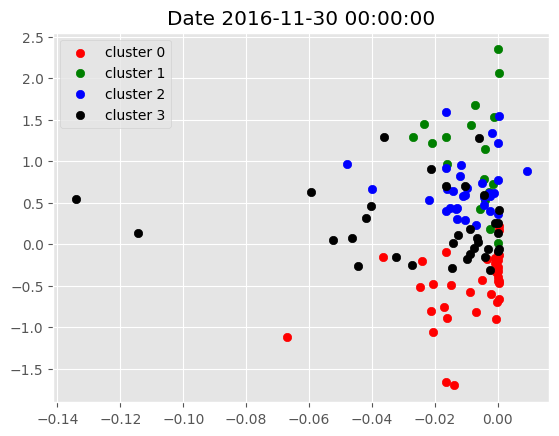

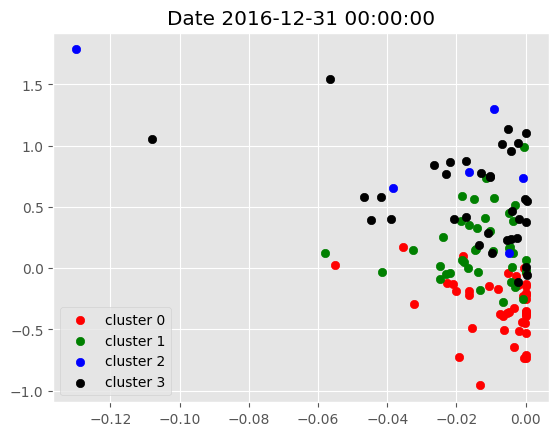

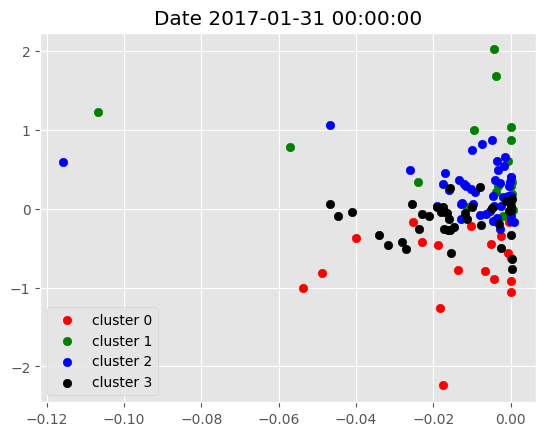

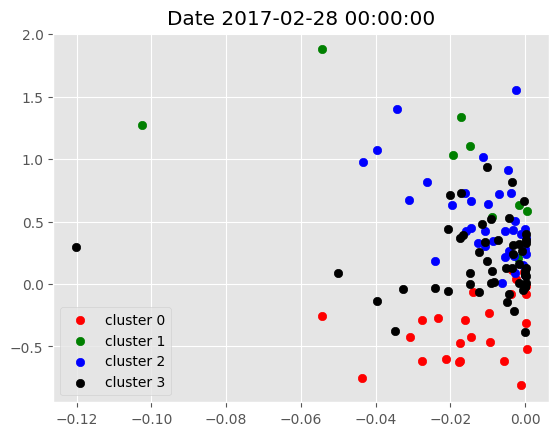

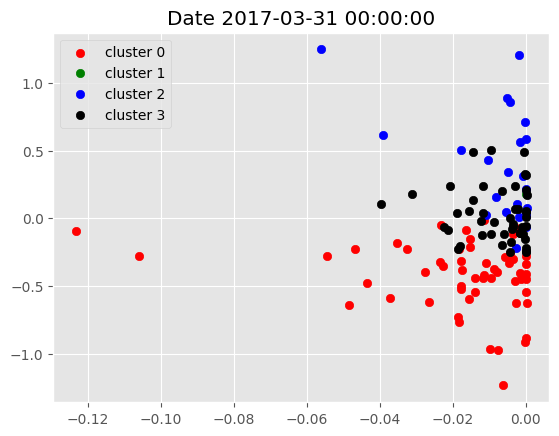

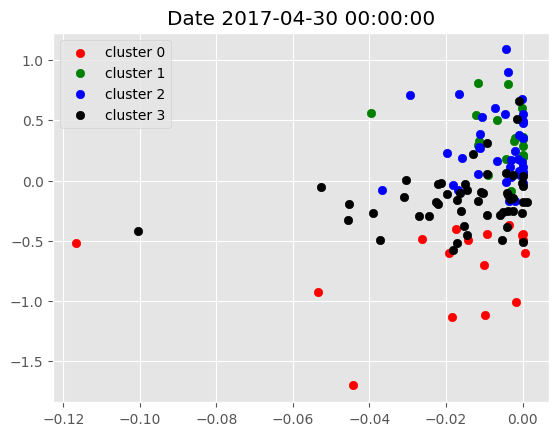

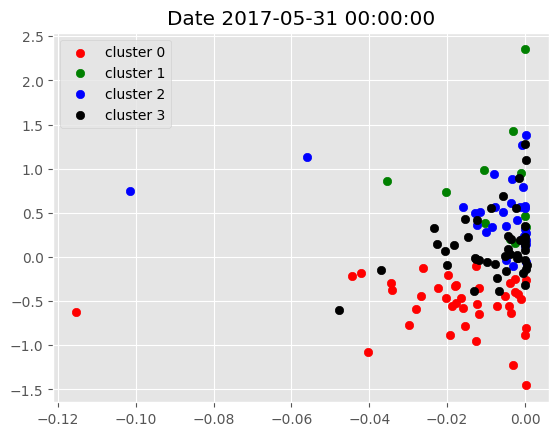

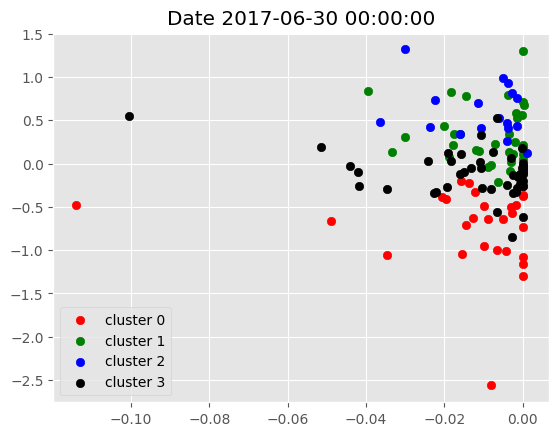

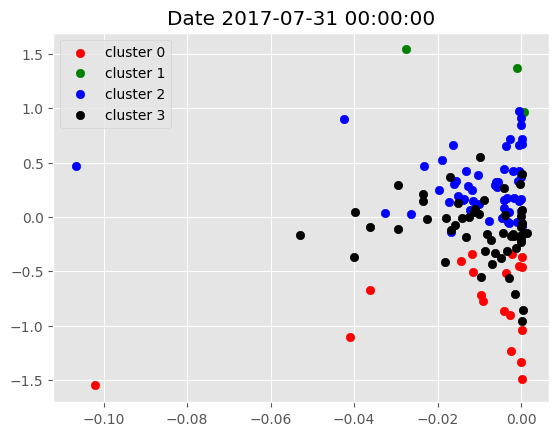

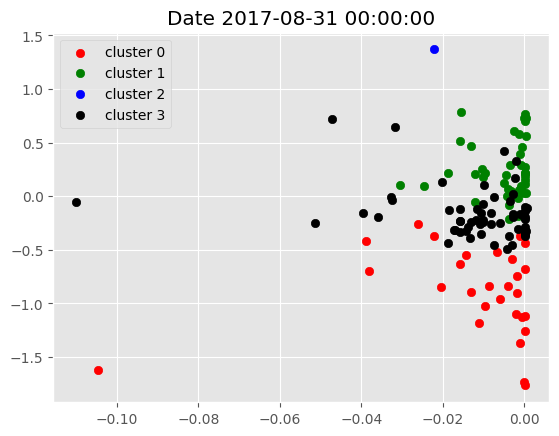

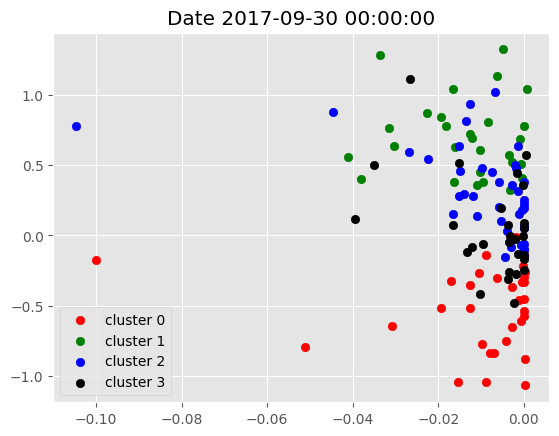

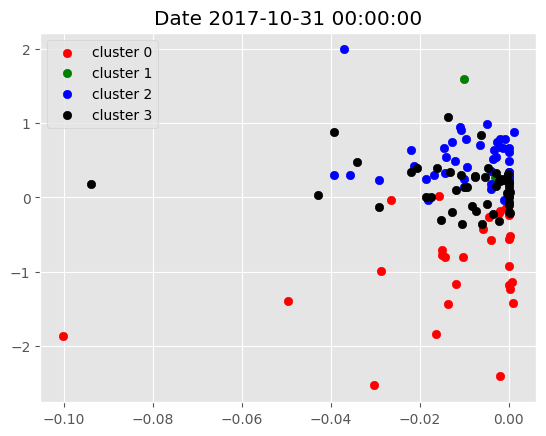

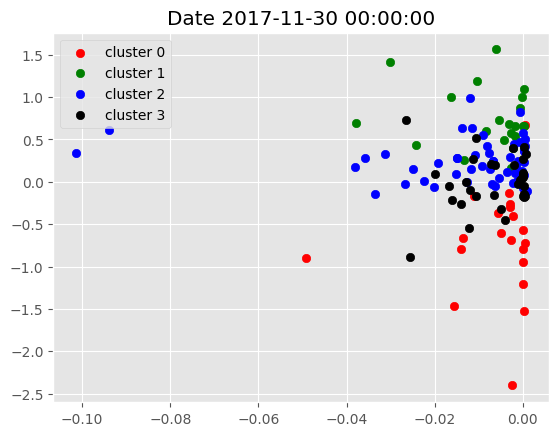

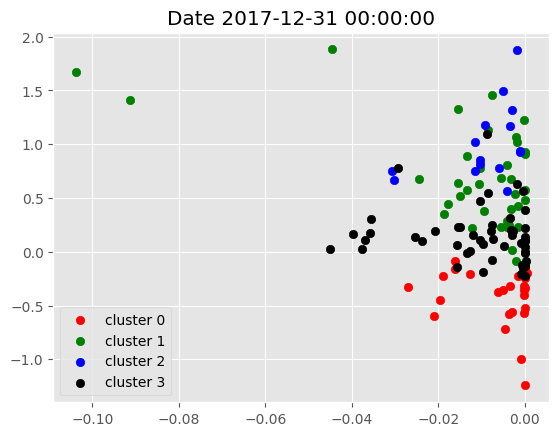

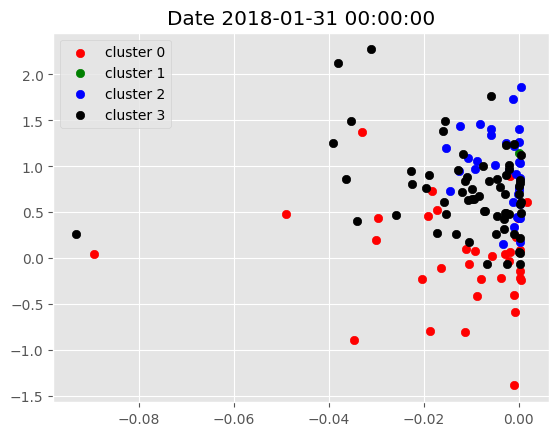

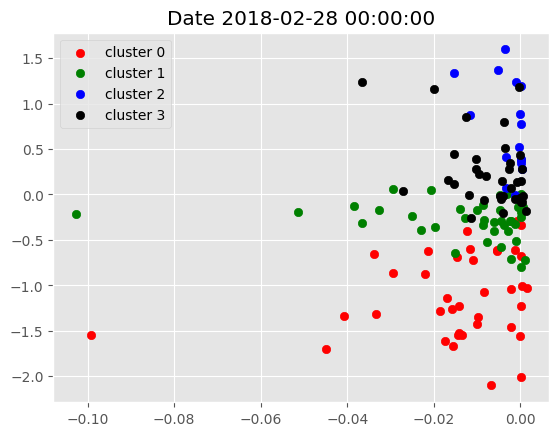

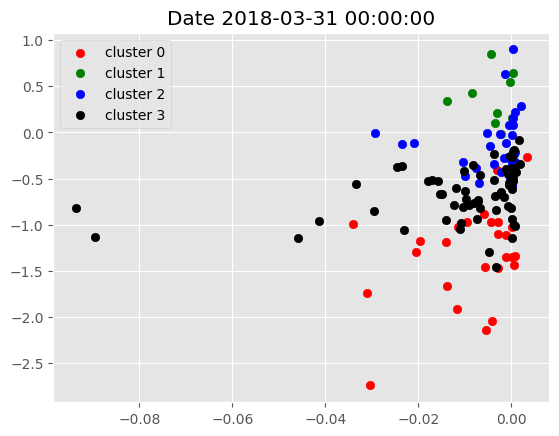

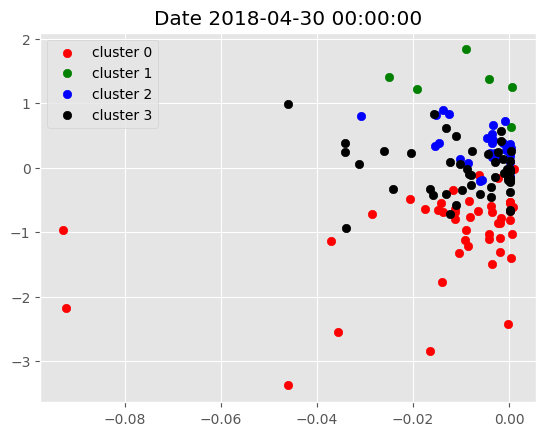

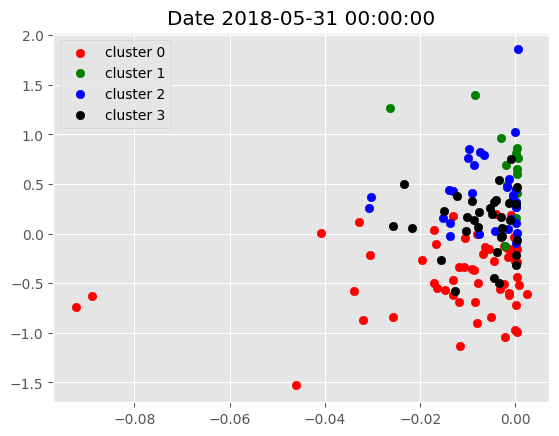

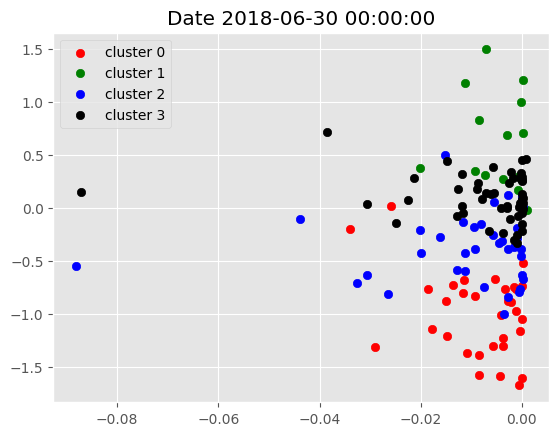

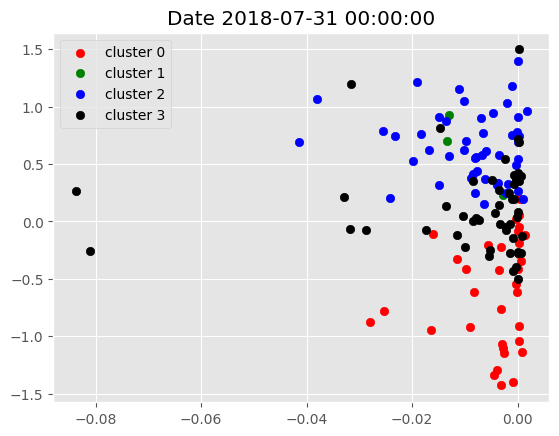

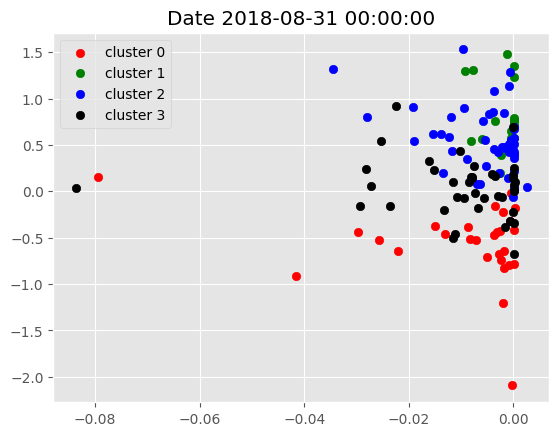

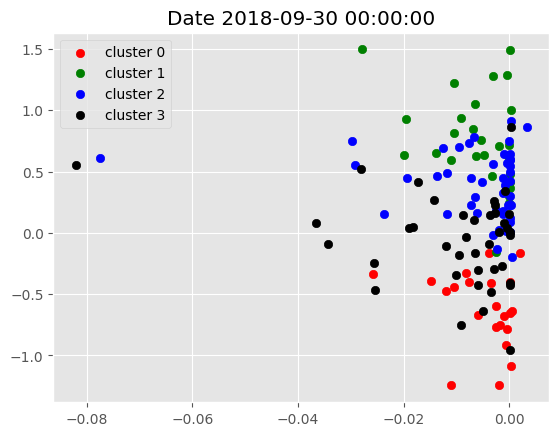

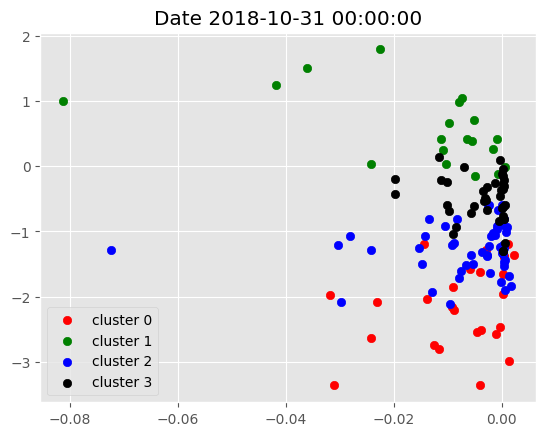

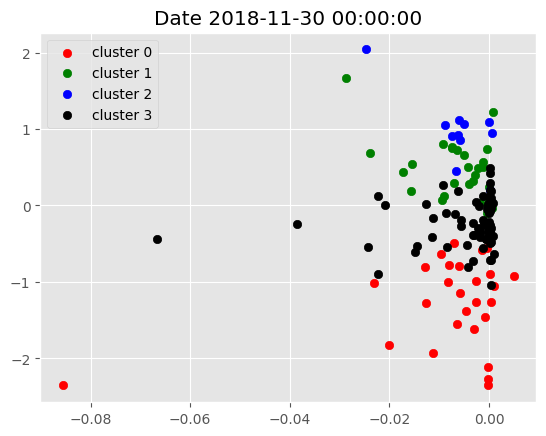

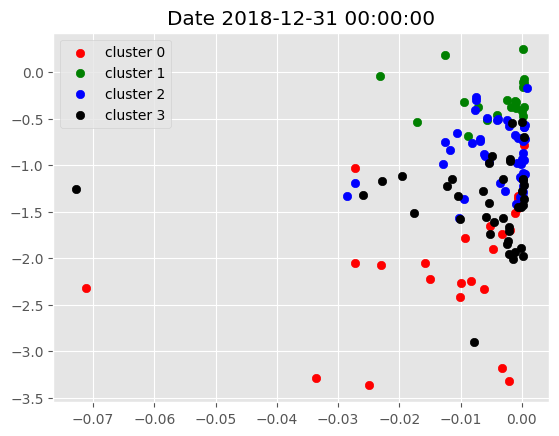

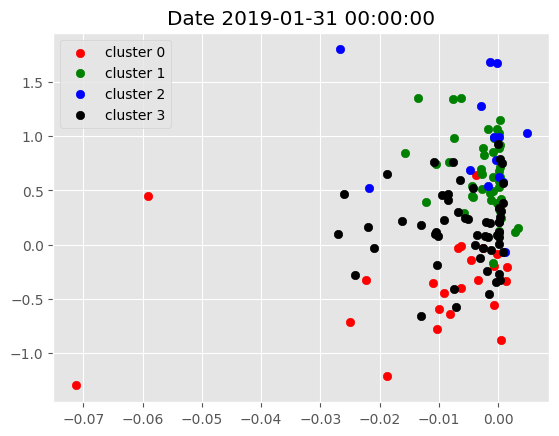

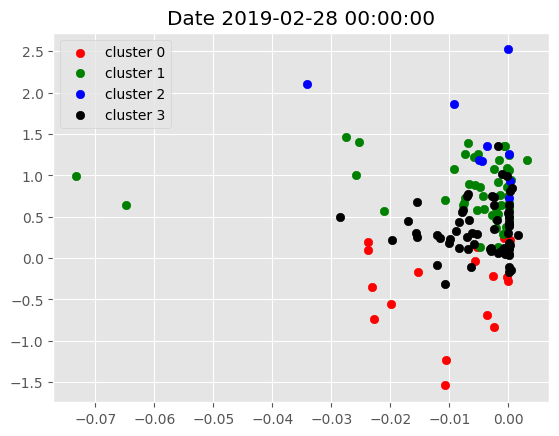

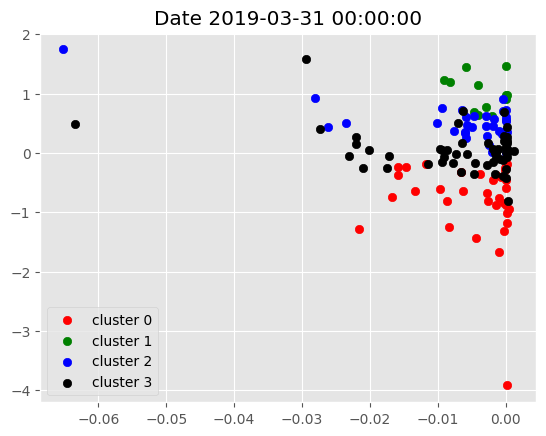

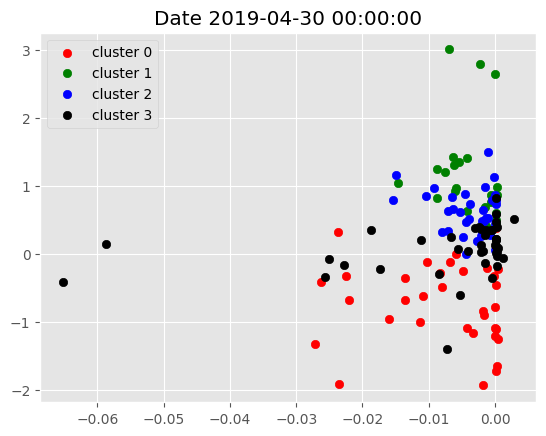

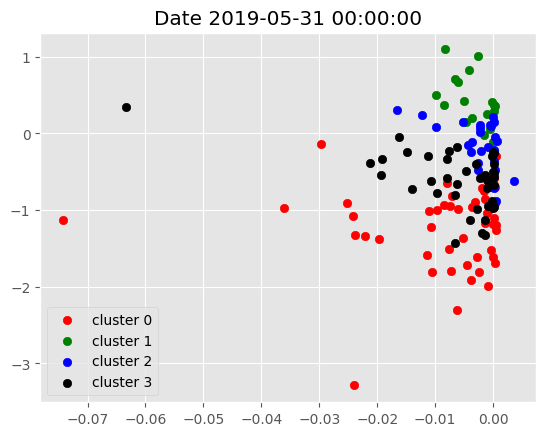

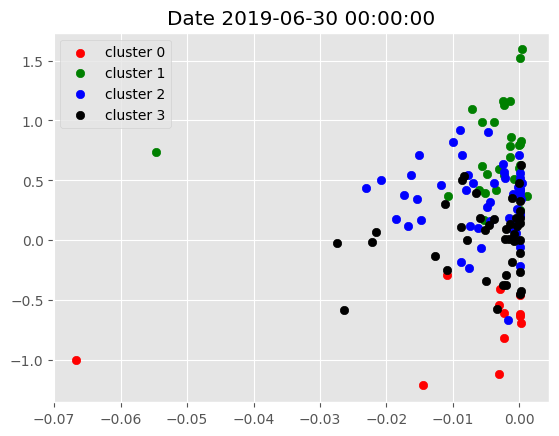

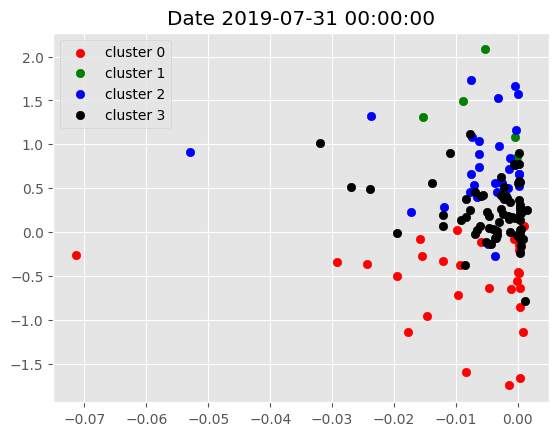

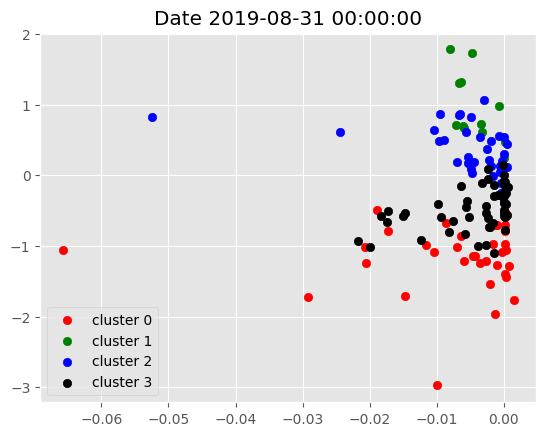

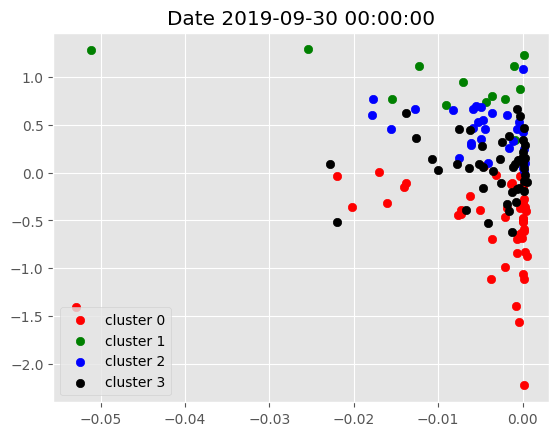

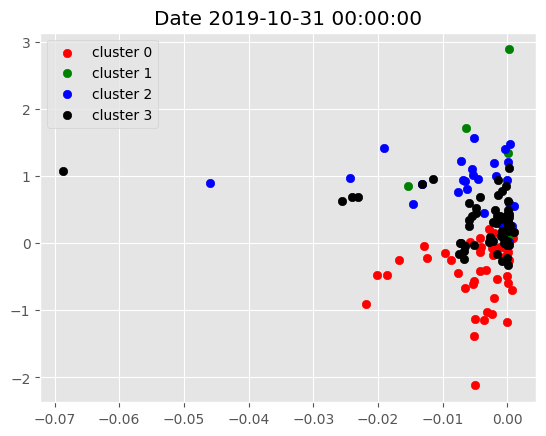

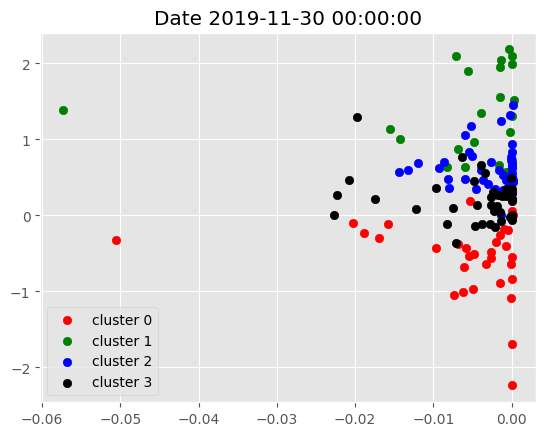

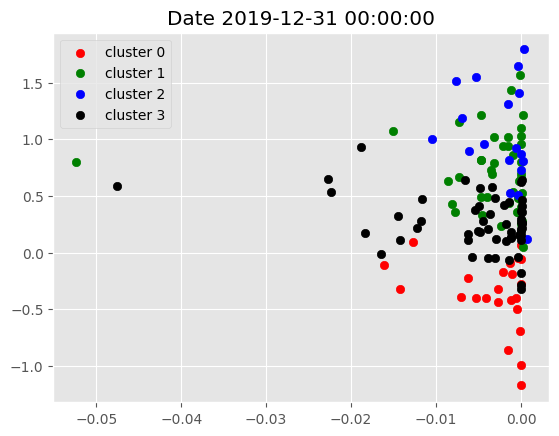

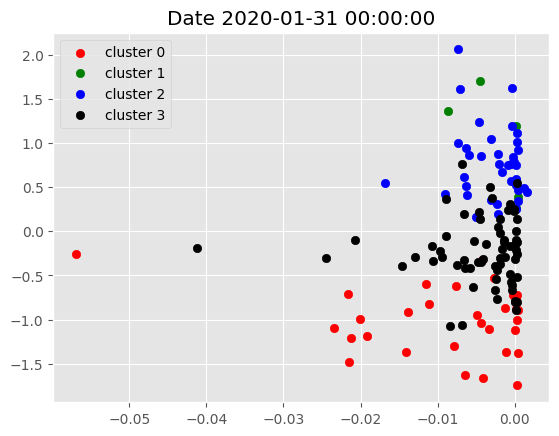

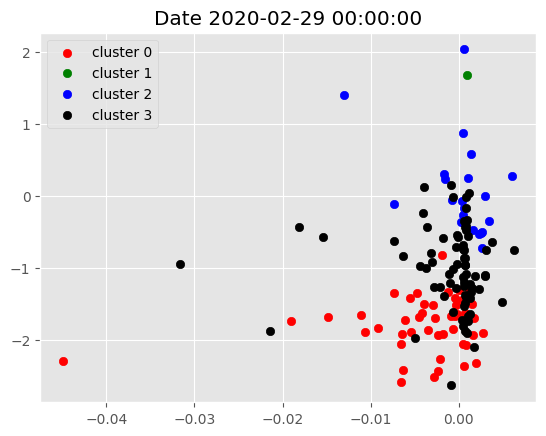

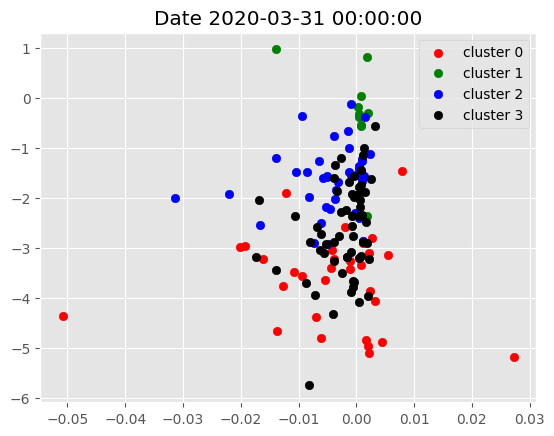

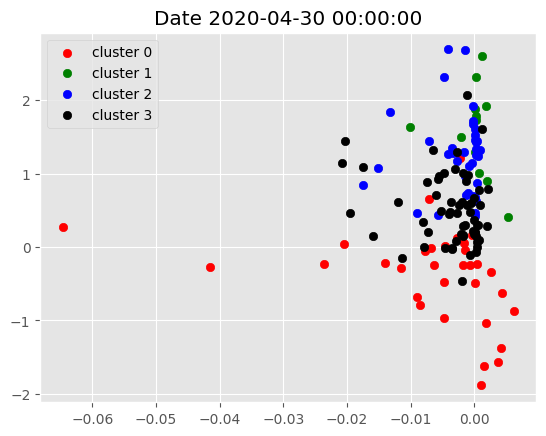

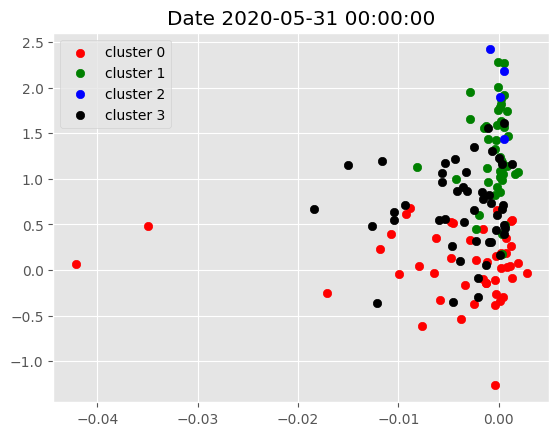

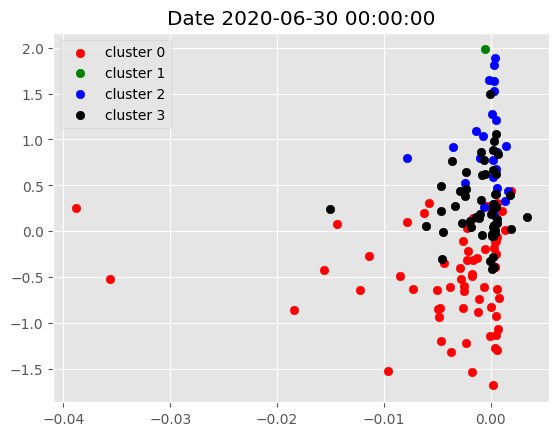

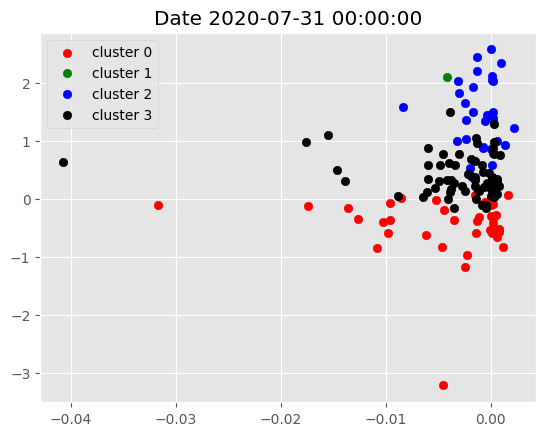

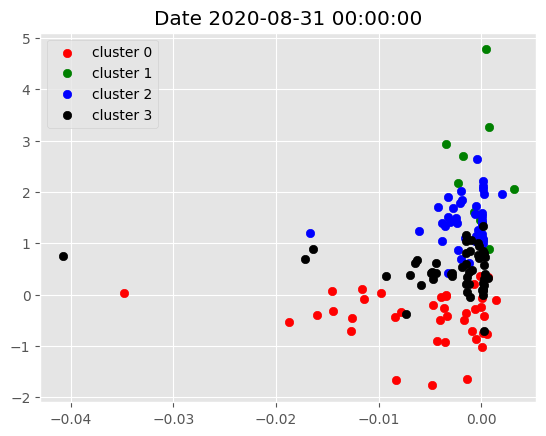

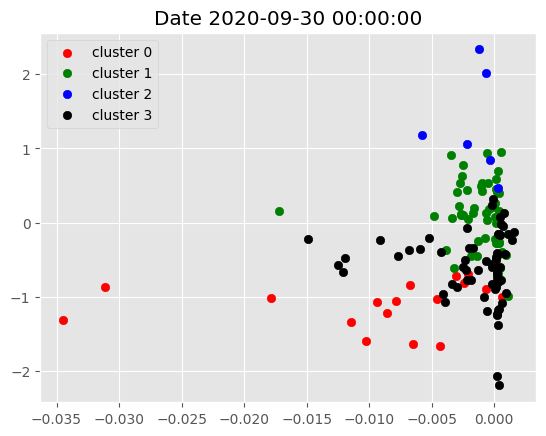

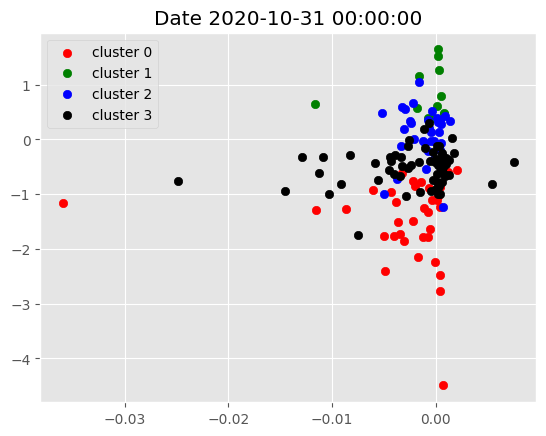

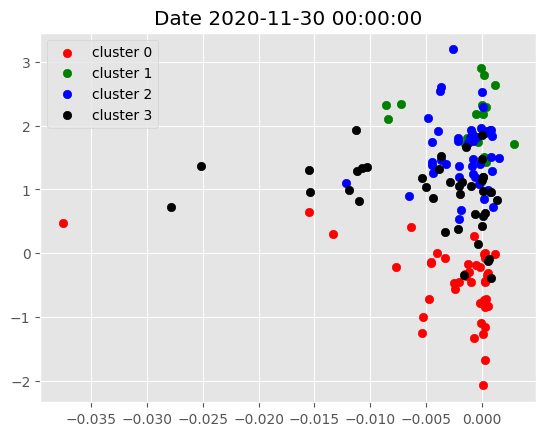

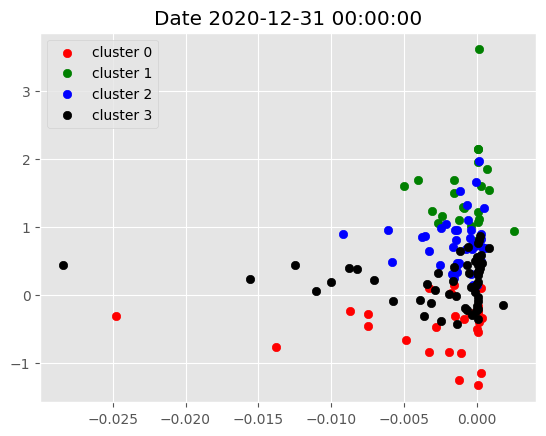

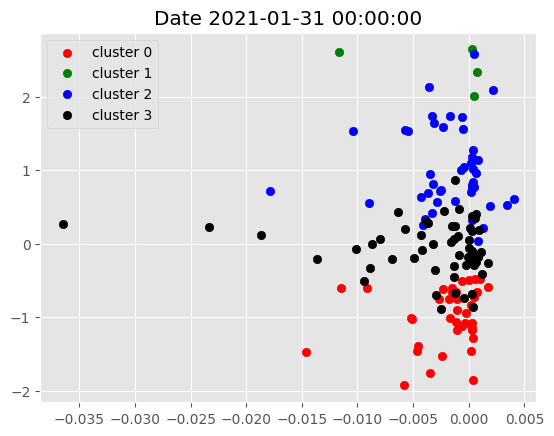

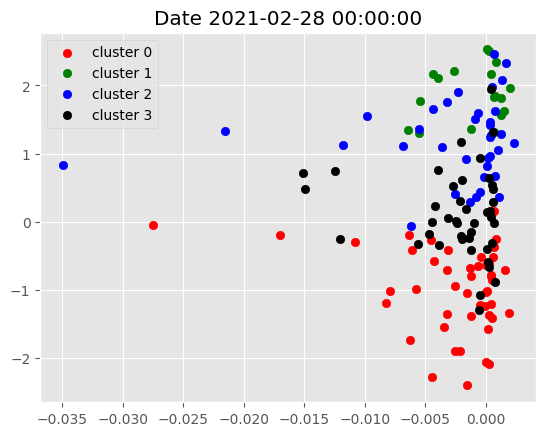

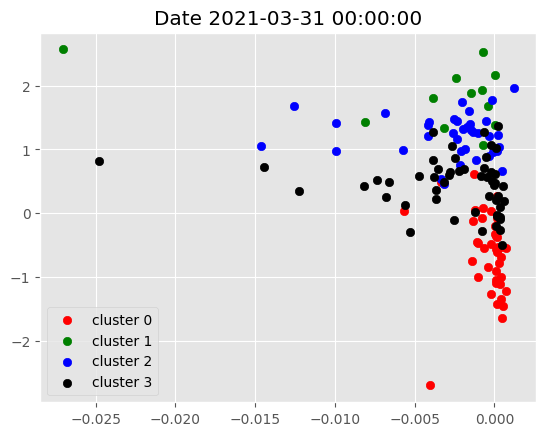

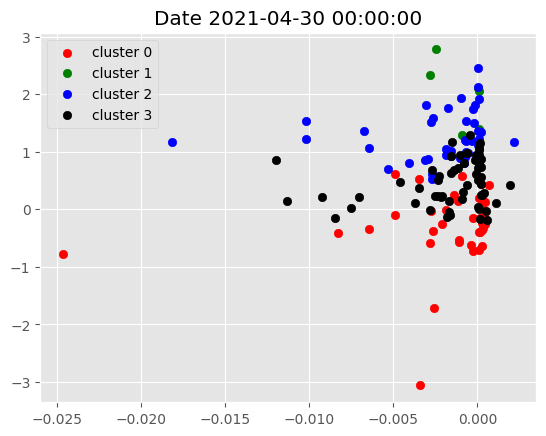

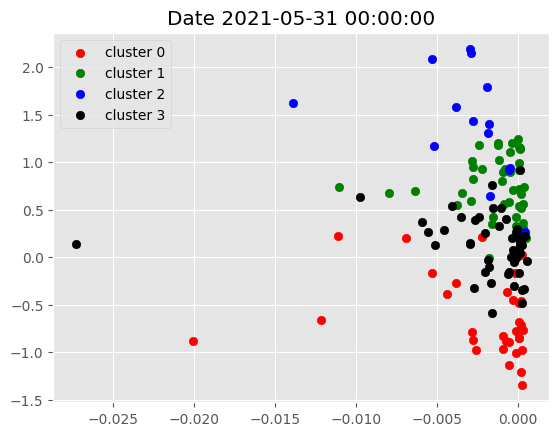

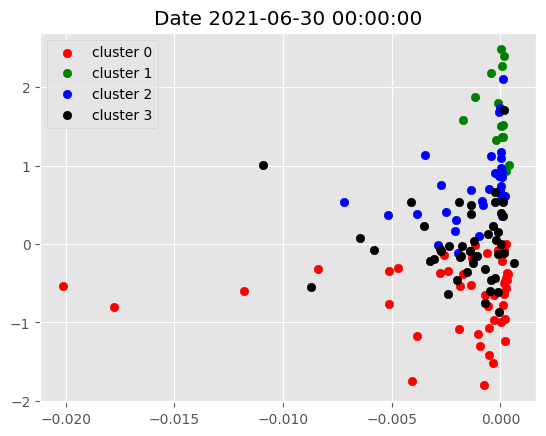

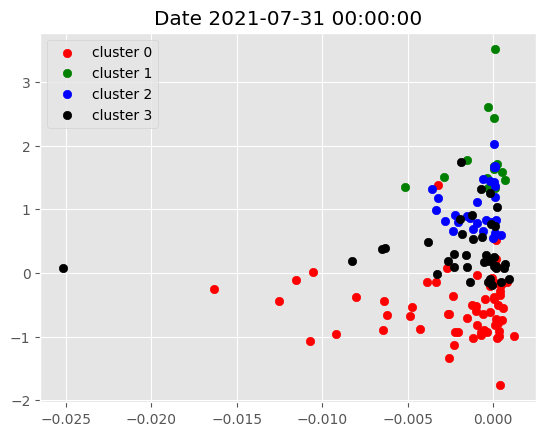

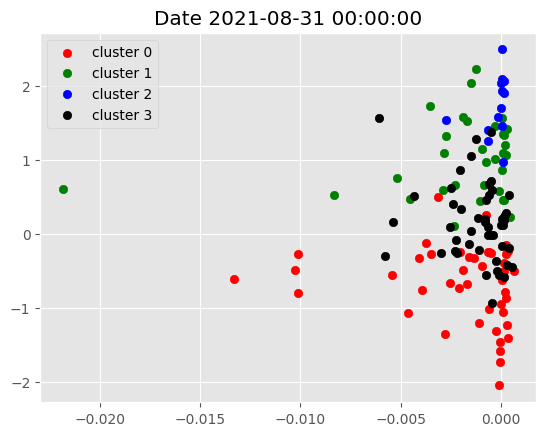

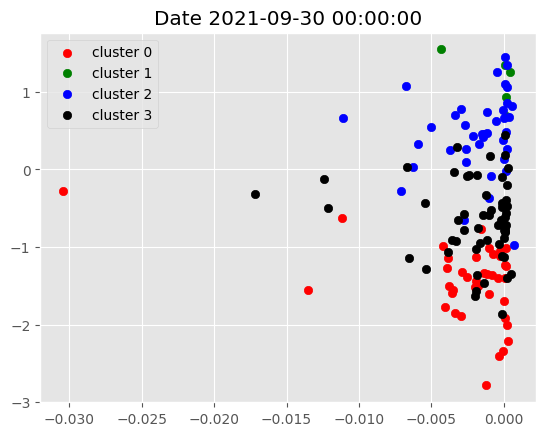

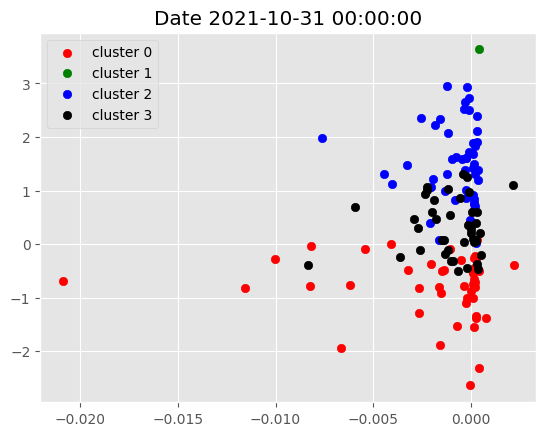

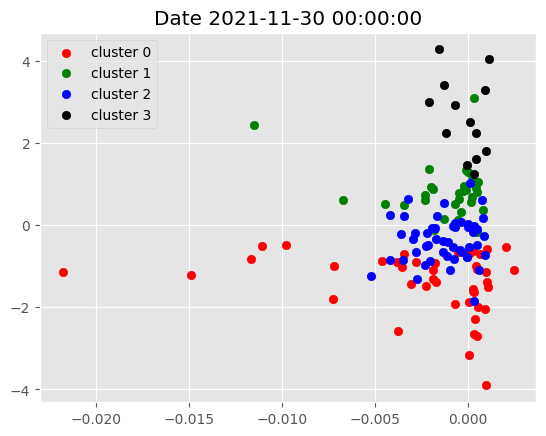

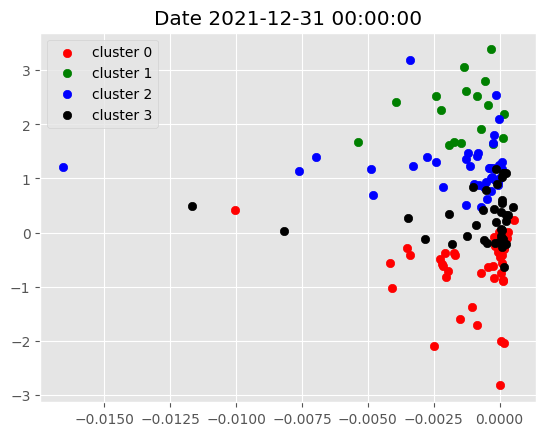

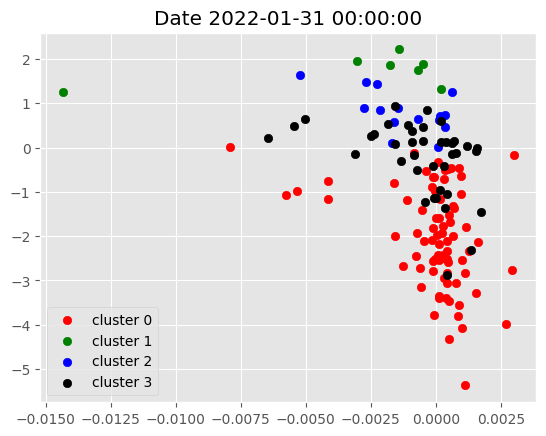

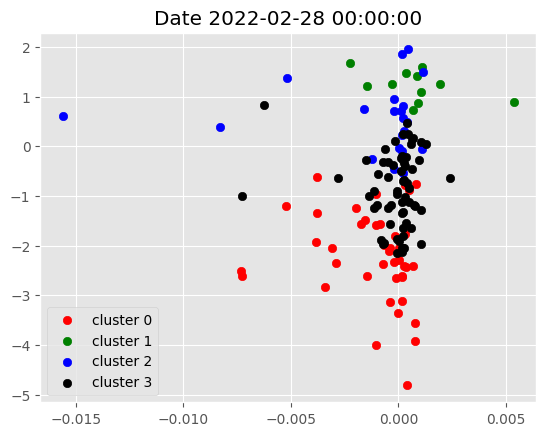

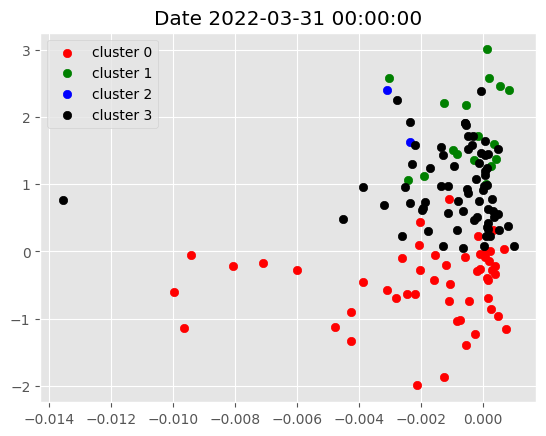

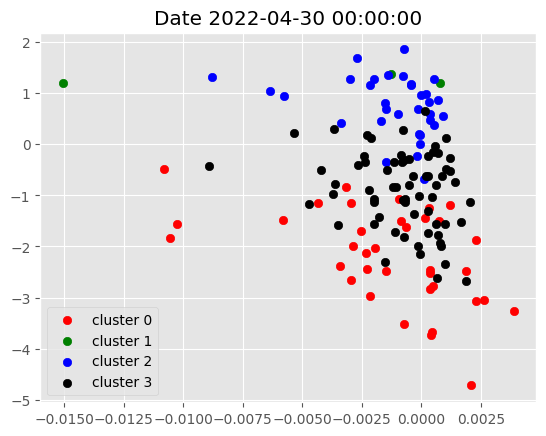

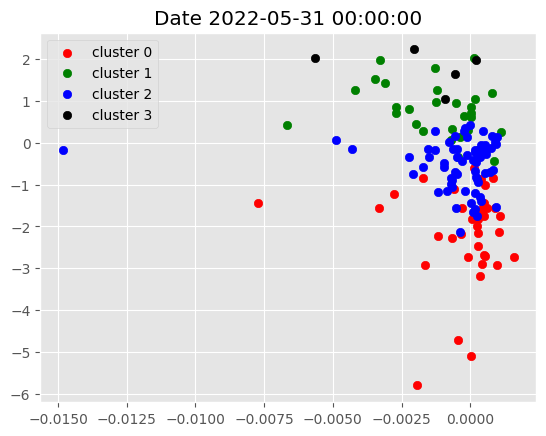

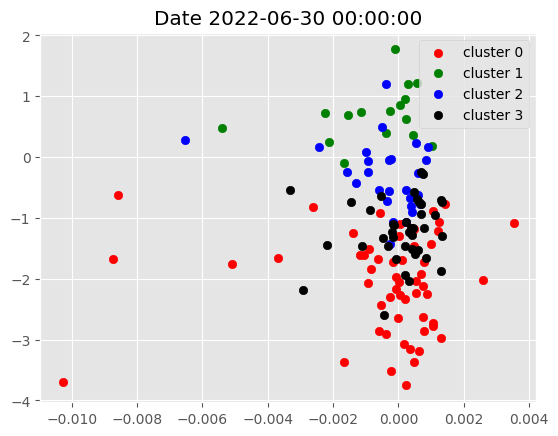

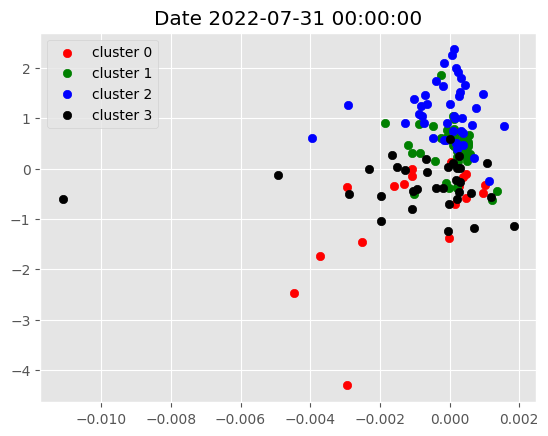

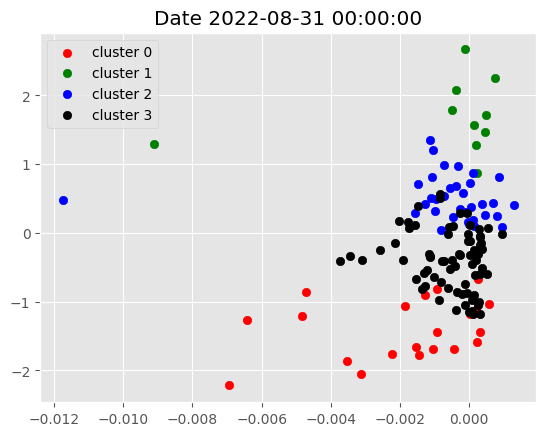

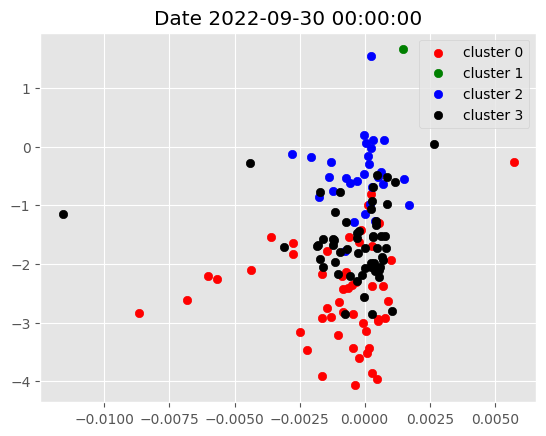

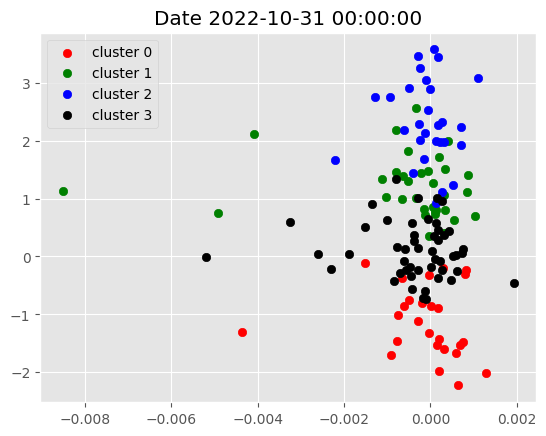

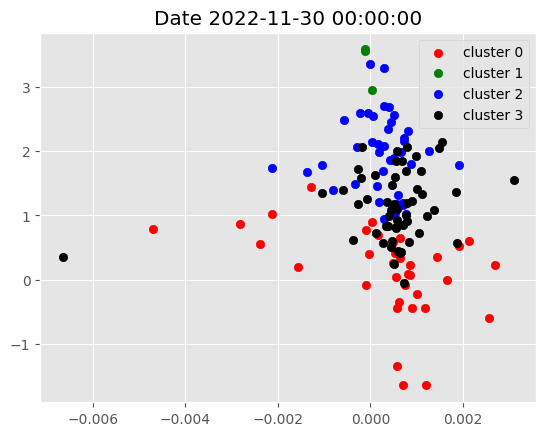

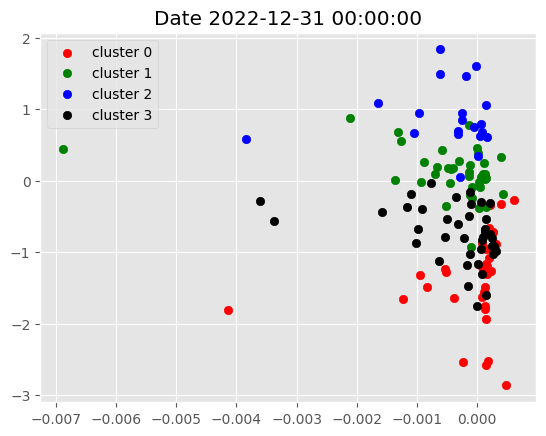

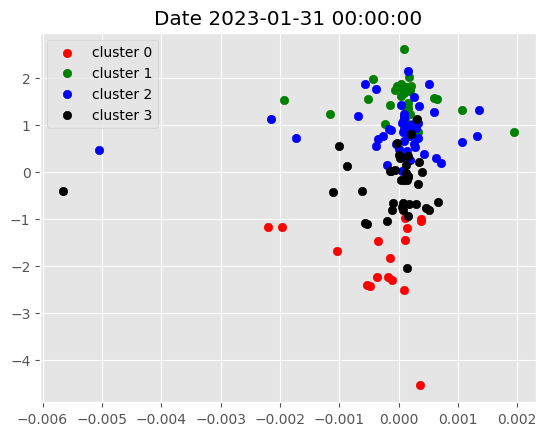

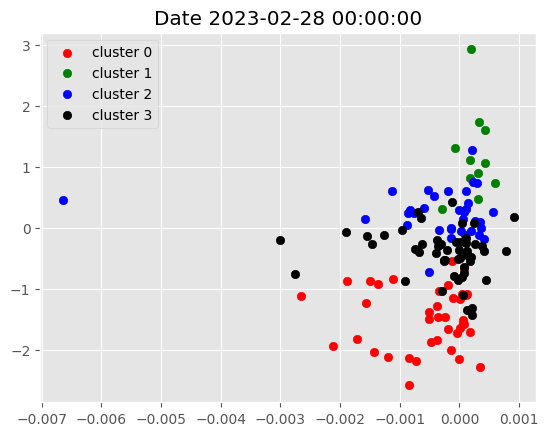

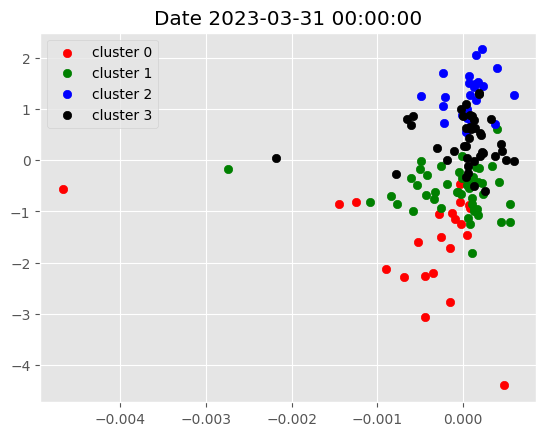

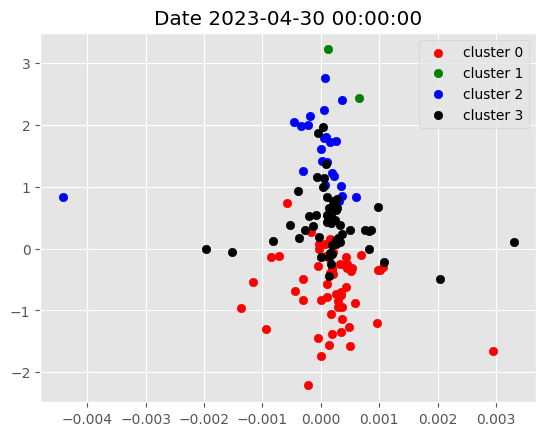

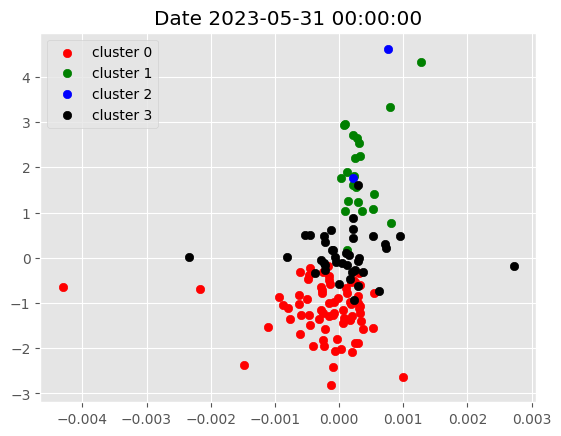

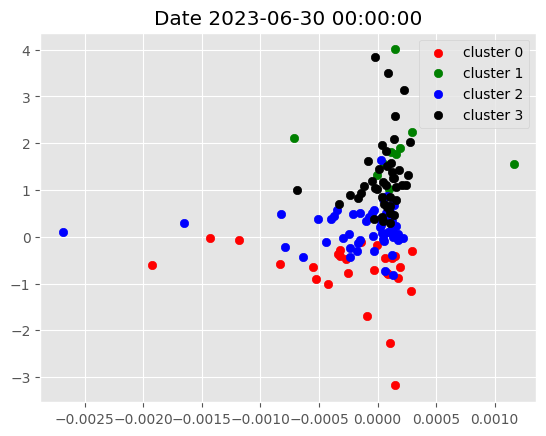

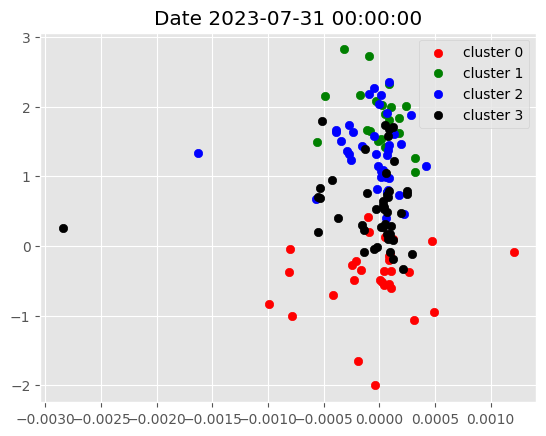

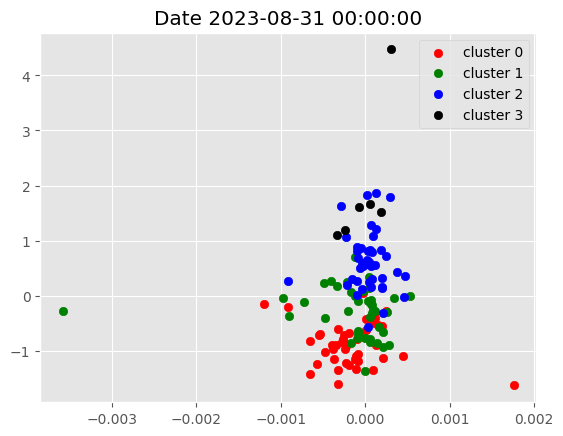

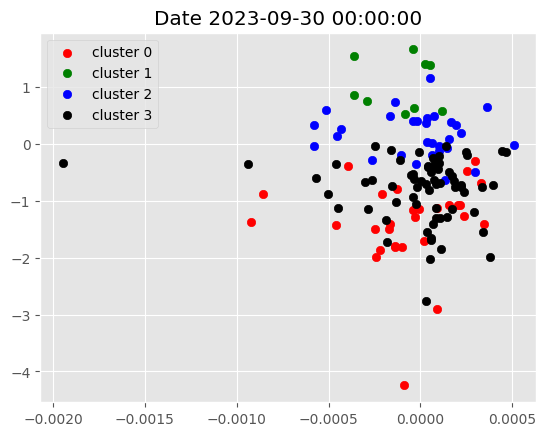

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [ ]:
# CLUSTER 1 is the most overbought so we are going to proc